In [ ]:
!pip install torch torchvision matplotlib numpy

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

### Import necessary Libraries

In [ ]:
import json
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset, Subset
import pandas as pd
import os

In [ ]:
#from tensorflow.python.client import device_lib
#device_lib.list_local_devices()

# Get the available devices
devices = [torch.cuda.device(i) for i in range(torch.cuda.device_count())]

# Print the available devices
print("Available devices:")
for device in devices:
    print(f"- {device}")

# Print the current device
#print(f"Current device: {torch.cuda.current_device()}")

Available devices:


In [ ]:
# Multiclass classification
#Predict if an asset will fail within two different intervals related to the two different decisions


`os`: This module provides functions for interacting with the operating system. It's commonly used for tasks such as file manipulation and directory operations.<br>
`sklearn.preprocessing`: This module from scikit-learn provides functions for preprocessing data, such as scaling, normalization, and encoding categorical variables.<br>
`sklearn.metrics`: This module contains functions for evaluating model performance, such as computing confusion matrices, recall scores, and precision scores.<br>
`multiclass_model_w1_30.h5`:The .h5 extension indicates that the model will be saved in the Hierarchical Data Format version 5 (HDF5) format, which is commonly used for storing large numerical datasets. The model will be saved with the filename **multiclass_model_w1_30.h5.**

In [ ]:
# Setting seed for reproducibility
np.random.seed(1234)
PYTHONHASHSEED = 0

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
#from tensorflow.keras.models import Sequential,load_model
#from tensorflow.keras.layers import Dense, Dropout, LSTM

# define path to save model
model_path = 'multiclass_model_w1_30.h5'# This file then contains the already trained network, so that you don't have to retrain every time

## Data Ingestion

In [ ]:
# read training data - It is the aircraft engine run-to-failure data.
train_df = pd.read_csv('PM_train.txt', sep=" ", header=None)
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN


In [ ]:
train_df.shape

(20631, 28)

`train_df.sort_values(['id','cycle'])`: This line sorts the DataFrame **train_df** first by the 'id' column and then by the 'cycle' column. It ensures that the data is ordered by engine ID and cycle number, which may be necessary for certain analyses or modeling tasks. The sorted DataFrame is then assigned back to the variable **train_df**.

In [ ]:
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

train_df = train_df.sort_values(['id','cycle'])

In [ ]:
train_df

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640


## Data Preprocessing
data preprocessing step, particularly for labeling the data for training purposes. Let's break down what each part of the code does:


>`Data Labeling`: This part calculates the Remaining Useful Life (RUL) or Time to Failure for each engine by finding the maximum cycle number (cycle) for each engine ID (id). The result is stored in a DataFrame rul with columns 'id' and 'max'.<br>

In [ ]:
#######
# TRAIN
#######
# Data Labeling - generate column RUL(Remaining Usefull Life or Time to Failure)
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()

In [ ]:
rul

,id,cycle
0,1,192
1,2,287
2,3,179
3,4,189
4,5,269
...,...,...
95,96,336
96,97,202
97,98,156
98,99,185


>`Merge RUL with Training Data`:the RUL information is merged back into the original training DataFrame **train_df** based on the engine ID. This allows each row in train_df to have the corresponding maximum cycle number as well.<br>

In [ ]:
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')

In [ ]:
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,max
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,192
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,192
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,192
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,192
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,192


>`Calculate RUL`: This line calculates the RUL by subtracting the current cycle number ('cycle') from the maximum cycle number ('max') for each engine. This represents how many more cycles the engine is expected to operate before failure.<br>
>`Drop Unnecessary Columns`: After calculating RUL, the 'max' column, which was used temporarily to calculate RUL, is dropped from the DataFrame as it's no longer needed.<br>

In [ ]:
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)
train_df.head(100)

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1,96,-0.0034,0.0001,100.0,518.67,642.19,1584.07,1395.16,14.62,...,2388.06,8130.69,8.4311,0.03,392,2388,100.0,38.88,23.3255,96
96,1,97,0.0035,-0.0003,100.0,518.67,642.07,1595.77,1407.81,14.62,...,2388.06,8128.74,8.4105,0.03,392,2388,100.0,39.01,23.2963,95
97,1,98,0.0006,0.0004,100.0,518.67,642.00,1591.11,1404.56,14.62,...,2388.06,8127.89,8.4012,0.03,391,2388,100.0,38.96,23.2554,94
98,1,99,-0.0005,-0.0000,100.0,518.67,642.46,1592.73,1406.13,14.62,...,2388.10,8131.77,8.4481,0.03,393,2388,100.0,38.82,23.2323,93


> `Labeling for Classification`: This part assigns labels to each data point based on the calculated RUL. It defines thresholds `w1` and `w0`, and assigns:
>> * Label 1 ('label1') as 1 if RUL is less than or equal to 'w1', and 0 otherwise.
>> * Label2 ('label2') as 1 if RUL is less than or equal to 'w1', 2 if RUL is less than or equal to 'w0', and 0 otherwise.

In [ ]:
w1 = 30
w0 = 10
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0 )
train_df['label2'] = train_df['label1']
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2

In [ ]:
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,RUL,label1,label2
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8.4195,0.03,392,2388,100.0,39.06,23.4190,191,0,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8.4318,0.03,392,2388,100.0,39.00,23.4236,190,0,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8.4178,0.03,390,2388,100.0,38.95,23.3442,189,0,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8.3682,0.03,392,2388,100.0,38.88,23.3739,188,0,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8.4294,0.03,393,2388,100.0,38.90,23.4044,187,0,0


In [ ]:
train_df.shape

(20631, 29)

## Now I want to separate the train_df set into a training/validation/test set. I will use 80% training sets for the training and 10% training sets as validation sets for hyperparameter tuning and the remaining 10% as test set for the PdM policy.

In [18]:
list_ID1 = np.arange(81,91,1) # I take the 20 last #TODO: make this random
list_ID2 = np.arange(91,101,1) # I take the 20 last #TODO: make this random
list_ID3 = np.arange(81,101,1) # I take the 20 last #TODO: make this random

## I separate into training and validation and test set before any data scaling is performed

In [19]:
validation_df = train_df.loc[train_df['id'].isin(list_ID1)]
test_df = train_df.loc[train_df['id'].isin(list_ID2)]

In [20]:
test_df.shape

(2251, 29)

In [21]:
validation_df.shape

(2242, 29)

In [22]:
train_df = train_df[~train_df.id.isin(list_ID3)]
train_df.shape

(16138, 29)

In [23]:
train_df

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,RUL,label1,label2
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8.4195,0.03,392,2388,100.0,39.06,23.4190,191,0,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8.4318,0.03,392,2388,100.0,39.00,23.4236,190,0,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8.4178,0.03,390,2388,100.0,38.95,23.3442,189,0,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8.3682,0.03,392,2388,100.0,38.88,23.3739,188,0,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8.4294,0.03,393,2388,100.0,38.90,23.4044,187,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16133,80,181,0.0042,0.0002,100.0,518.67,644.00,1604.26,1428.92,14.62,...,8.5194,0.03,397,2388,100.0,38.39,23.1678,4,1,2
16134,80,182,-0.0014,0.0004,100.0,518.67,643.81,1598.32,1426.31,14.62,...,8.5493,0.03,396,2388,100.0,38.34,23.0142,3,1,2
16135,80,183,0.0018,-0.0000,100.0,518.67,643.49,1603.37,1434.30,14.62,...,8.5106,0.03,397,2388,100.0,38.34,22.9337,2,1,2
16136,80,184,-0.0024,0.0002,100.0,518.67,643.83,1603.01,1430.23,14.62,...,8.4983,0.03,397,2388,100.0,38.53,22.9971,1,1,2


# Perform the min max scaling on the training data and validation dataset
# use min_max_scaler.fit_transform()

>`Create a copy of the cycle column`: This line creates a new column named 'cycle_norm' in the train_df DataFrame and initializes it with the values from the original 'cycle' column. This column will be normalized later.<br>
> `Select columns for normalization`: This line selects all columns from **train_df** except 'id', 'cycle', 'RUL', 'label1', and 'label2'. These columns are the ones that will undergo normalization.


In [24]:
train_df['cycle_norm'] = train_df['cycle']
validation_df['cycle_norm'] = validation_df['cycle']
cols_normalize_train = train_df.columns.difference(['id','cycle','RUL','label1','label2'])
cols_normalize_validation = validation_df.columns.difference(['id','cycle','RUL','label1','label2'])

> `Initialize MinMaxScaler`: This line initializes a MinMaxScaler object from the scikit-learn preprocessing module. This scaler will be used to perform Min-Max normalization.<br>
> `Perform Min-Max normalization`: This line applies Min-Max normalization to the selected columns (`cols_normalize`) of the `train_df` DataFrame.<br>
> `min_max_scaler.fit_transform(train_df[cols_normalize])` computes the Min-Max normalization for the selected columns.<br>
> The resulting normalized values are stored in a new DataFrame called `norm_train_df`, with the same index as `train_df`.

In [25]:
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize_train]),
                             columns=cols_normalize_train,
                             index=train_df.index)

norm_validation_df = pd.DataFrame(min_max_scaler.fit_transform(validation_df[cols_normalize_validation]),
                             columns=cols_normalize_validation,
                             index=validation_df.index)

> `Join normalized DataFrame with the original DataFrame`: This line joins the normalized DataFrame (`norm_train_df`) with the original DataFrame (`train_df`) excluding the columns that were normalized.<br>
> The resulting DataFrame `join_df` contains both the normalized columns and the original columns that were not normalized.


In [26]:
# MinMax normalization (from 0 to 1)
join_df_train = train_df[train_df.columns.difference(cols_normalize_train)].join(norm_train_df)
join_df_validation = validation_df[validation_df.columns.difference(cols_normalize_validation)].join(norm_validation_df)


`Reorder columns`:
> * This line reorders the columns of `join_df` to match the original order of columns in `train_df`.
> * The reordered DataFrame is then assigned back to `train_df`, effectively replacing the original DataFrame with the normalized version.






In [27]:
train_df = join_df_train.reindex(columns = train_df.columns)
validation_df = join_df_validation.reindex(columns = validation_df.columns)

In [28]:
train_df

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s16,s17,s18,s19,s20,s21,RUL,label1,label2,cycle_norm
0,1,1,0.456647,0.166667,0.0,0.0,0.183735,0.425154,0.309757,0.0,...,0.0,0.363636,0.0,0.0,0.708661,0.725482,191,0,0,0.000000
1,1,2,0.606936,0.250000,0.0,0.0,0.283133,0.473456,0.352633,0.0,...,0.0,0.363636,0.0,0.0,0.661417,0.732001,190,0,0,0.002770
2,1,3,0.248555,0.750000,0.0,0.0,0.343373,0.386193,0.370527,0.0,...,0.0,0.181818,0.0,0.0,0.622047,0.619473,189,0,0,0.005540
3,1,4,0.537572,0.500000,0.0,0.0,0.343373,0.267715,0.331195,0.0,...,0.0,0.363636,0.0,0.0,0.566929,0.661565,188,0,0,0.008310
4,1,5,0.387283,0.333333,0.0,0.0,0.349398,0.269082,0.404625,0.0,...,0.0,0.454545,0.0,0.0,0.582677,0.704790,187,0,0,0.011080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16133,80,181,0.739884,0.666667,0.0,0.0,0.840361,0.756892,0.787812,0.0,...,0.0,0.818182,0.0,0.0,0.181102,0.369473,4,1,2,0.498615
16134,80,182,0.416185,0.833333,0.0,0.0,0.783133,0.621554,0.743754,0.0,...,0.0,0.727273,0.0,0.0,0.141732,0.151786,3,1,2,0.501385
16135,80,183,0.601156,0.500000,0.0,0.0,0.686747,0.736614,0.878629,0.0,...,0.0,0.818182,0.0,0.0,0.141732,0.037698,2,1,2,0.504155
16136,80,184,0.358382,0.666667,0.0,0.0,0.789157,0.728412,0.809926,0.0,...,0.0,0.818182,0.0,0.0,0.291339,0.127551,1,1,2,0.506925


In [29]:
validation_df

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s16,s17,s18,s19,s20,s21,RUL,label1,label2,cycle_norm
16138,81,1,0.232704,0.750000,0.0,0.0,0.255663,0.465317,0.402390,0.0,...,0.0,0.2,0.0,0.0,0.612613,0.577044,239,0,0,0.000000
16139,81,2,0.691824,0.666667,0.0,0.0,0.453074,0.374969,0.426479,0.0,...,0.0,0.3,0.0,0.0,0.648649,0.590098,238,0,0,0.003425
16140,81,3,0.515723,0.916667,0.0,0.0,0.420712,0.379166,0.205242,0.0,...,0.0,0.5,0.0,0.0,0.765766,0.613803,237,0,0,0.006849
16141,81,4,0.540881,0.500000,0.0,0.0,0.375405,0.588250,0.368279,0.0,...,0.0,0.3,0.0,0.0,0.522523,0.703226,236,0,0,0.010274
16142,81,5,0.698113,0.666667,0.0,0.0,0.699029,0.479635,0.459241,0.0,...,0.0,0.3,0.0,0.0,0.765766,0.568942,235,0,0,0.013699
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18375,90,150,0.735849,0.416667,0.0,0.0,0.760518,0.732905,0.671035,0.0,...,0.0,0.6,0.0,0.0,0.153153,0.354989,4,1,2,0.510274
18376,90,151,0.666667,0.583333,0.0,0.0,0.773463,0.587262,0.784159,0.0,...,0.0,0.8,0.0,0.0,0.360360,0.219355,3,1,2,0.513699
18377,90,152,0.515723,0.500000,0.0,0.0,0.889968,0.780548,0.705338,0.0,...,0.0,0.6,0.0,0.0,0.189189,0.217554,2,1,2,0.517123
18378,90,153,0.691824,0.666667,0.0,0.0,0.708738,0.944705,0.843130,0.0,...,0.0,0.7,0.0,0.0,0.117117,0.023856,1,1,2,0.520548


In [30]:
train_df['cycle'].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [31]:
train_df.shape

(16138, 30)

## Vanilla Transformer

In [32]:
# pick a large window size of 50 cycles. This sets the length of the sequence window to 50 cycles.
sequence_length = 50

# function to reshape features into (samples, time steps, features)
def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    # for one id I put all the rows in a single matrix
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    # Iterate over two lists in parallel.
    # For example id1 have 192 rows and sequence_length is equal to 50
    # so zip iterate over two following list of numbers (0,112),(50,192)
    # 0 50 -> from row 0 to row 50
    # 1 51 -> from row 1 to row 51
    # 2 52 -> from row 2 to row 52
    # ...
    # 111 191 -> from row 111 to 191
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]




In [33]:
# pick the feature columns, This selects the columns to be included in the sequences.
# sensor_cols contains the sensor data columns (s1 to s21).
sensor_cols = ['s' + str(i) for i in range(1,22)]
#sequence_cols initially contains the operational settings columns (setting1, setting2, setting3, cycle_norm).
# Then, it's extended to include the sensor data columns as well.
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)

## generate sequences for each engine
> * This creates a generator expression that iterates over unique engine IDs in the training data.<br>
> * For each engine, it generates sequences using the `gen_sequence` function defined earlier.<br>
> * Each sequence is a list of sensor data, and multiple sequences are generated for each engine.<br>



In [34]:
seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols))
           for id in train_df['id'].unique())

seq_gen_validation = (list(gen_sequence(validation_df[validation_df['id']==id], sequence_length, sequence_cols))
           for id in validation_df['id'].unique())



In [35]:
seq_gen

<generator object <genexpr> at 0x7d9edf6937d0>

> * This concatenates all the generated sequences into a single numpy array.
> * It converts the array to `float32` data type.
> * The resulting `seq_array` contains the sequences of sensor data, with shape `(num_sequences, sequence_length, num_features)`.


In [36]:
# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
seq_array.shape

(12138, 50, 25)

In [37]:
# generate sequences and convert to numpy array
seq_array_validation = np.concatenate(list(seq_gen_validation)).astype(np.float32)
seq_array_validation.shape

(1742, 50, 25)

In [38]:
type(seq_array)

numpy.ndarray

In [39]:
seq_array[:,-5:,1]

array([[0.5833333 , 0.9166667 , 0.5833333 , 0.9166667 , 0.41666666],
       [0.9166667 , 0.5833333 , 0.9166667 , 0.41666666, 0.75      ],
       [0.5833333 , 0.9166667 , 0.41666666, 0.75      , 0.41666666],
       ...,
       [0.5       , 0.25      , 0.33333334, 0.6666667 , 0.8333333 ],
       [0.25      , 0.33333334, 0.6666667 , 0.8333333 , 0.5       ],
       [0.33333334, 0.6666667 , 0.8333333 , 0.5       , 0.6666667 ]],
      dtype=float32)

In [40]:
# we always take the measurements of the last 50 cycles as input!
# Every sequence is reduced by a length of 50 (=sequence_length). We have 80 training sets, 80*50 = 4000 "less" inputs
# train_df.shape = (16138, 30)
# seq_array.shape = (12138, 50, 25)

`Function Signature:` This function efficiently generates labels for each sequence of sensor data. It ensures that the labels are correctly aligned with the sequences and handles the special case where the first sequence uses the last label as its target.





> This function takes three arguments:
>> * `id_df:` DataFrame containing data for a specific engine (id).<br>
>> * `seq_length`: Length of the sequence window.<br>
>> * `label`: List of column names representing the labels.

`Data Preparation:`
> * `data_matrix = id_df[label].values:`
>> * This line extracts the columns specified by label from the DataFrame id_df and converts them to a numpy array.<br>
>> * It selects only the relevant label(s) needed for generating sequences.<br>

`Label Generation:`
> * `num_elements:`This line calculates the number of rows (elements) in the data matrix, which corresponds to the number of labels.<br>
> * `return data_matrix[seq_length:num_elements, :]:`
>> * This line returns the labels associated with each sequence.<br>
>> * It removes the first `seq_length` labels because, for each engine (`id`), the first sequence of size `seq_length` uses the last label as its target. The previous labels are discarded.<br>
>> * All subsequent sequences for the same engine (`id`) will have one label associated with them step by step.<br>








In [41]:
# function to generate labels
def gen_labels(id_df, seq_length, label):
    # For one id I put all the labels in a single matrix.
    # For example:
    # [[1]
    # [4]
    # [1]
    # [5]
    # [9]
    # ...
    # [200]]
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    # I have to remove the first seq_length labels
    # because for one id the first sequence of seq_length size have as target
    # the last label (the previous ones are discarded).
    # All the next id's sequences will have associated step by step one label as target.
    return data_matrix[seq_length:num_elements, :]

# generate labels for training and validation set
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['label2'])
             for id in train_df['id'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32)

label_gen_validation = [gen_labels(validation_df[validation_df['id']==id], sequence_length, ['label2'])
             for id in validation_df['id'].unique()]
label_array_validation = np.concatenate(label_gen_validation).astype(np.float32)
label_array.shape, label_array_validation.shape

((12138, 1), (1742, 1))

In [42]:
# When modeling multi-class classification problems using neural networks,
# it is good practice to reshape the output attribute from a vector that contains values for each class value to be
# a matrix with a boolean for each class value and whether or not a given instance has that class value or not.
# This is called one hot encoding or creating dummy variables from a categorical variable.

#from tensorflow.keras.utils import to_categorical

# Assuming your array is a numpy array named `data`
data = np.array([label_array]).reshape(-1)  # Ensure it is a 1D array of shape (12138,)
data_validation = np.array([label_array_validation]).reshape(-1)  # Ensure it is a 1D array of shape (12138,)

# Convert the numpy array to a PyTorch tensor
data_tensor = torch.tensor(data, dtype=torch.long)
data_tensor_validation = torch.tensor(data_validation, dtype=torch.long)

# Perform one-hot encoding
dummy_label_array = torch.nn.functional.one_hot(data_tensor)
dummy_label_array_validation = torch.nn.functional.one_hot(data_tensor_validation)

dummy_label_array=np.array(dummy_label_array, dtype=np.int64)  # Convert input to NumPy array
dummy_label_array_validation=np.array(dummy_label_array_validation, dtype=np.int64)  # Convert input to NumPy array



`to_categorical` is a utility function in Keras that converts class vectors (integers) to binary class matrices.<br>
`dummy_label_array = to_categorical(label_array):`This line applies one-hot encoding to the `label_array`.<br>
`label_array` contains the labels associated with each sequence, where each label represents a class or category.<br>
> * One-hot encoding converts these integer labels into binary vectors, where each vector has a length equal to the number of classes and contains a 1 in the position corresponding to the class and 0s elsewhere.





In [43]:
label_array.shape

(12138, 1)

In [44]:
label_array[:5]

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

In [45]:
type(label_array)

numpy.ndarray

In [46]:
dummy_label_array

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]])

In [47]:
dummy_label_array_validation

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]])

In [48]:
dummy_label_array.shape

(12138, 3)

In [49]:
nb_features = seq_array.shape[2]
nb_out      = dummy_label_array.shape[1]
nb_features, nb_out

(25, 3)

`Extracting Feature and Output Dimensions:`
> `nb_features:`Determines the number of features in the input sequence data.<br>
> `nb_out:`Determines the number of output classes. It's extracted from the shape of the label array.<br>

`Defining the Model Architecture:` describe in the code below.
`Compiling the Model:` `model.compile(...)` Here, `categorical_crossentropy` is used as the loss function for multi-class classification.

`Model Summary:`Prints a summary of the model architecture, including the layers and their parameters.

`Training the Model:` `model.fit(...):` Trains the model on the training data. It specifies the input data (`seq_array`) and the corresponding labels (`dummy_label_array`). Other parameters include the number of epochs, batch size, validation split, verbosity, and callbacks.<br>


`history.history.keys():` After training, this prints the keys of the history object, which contains information about training and validation metrics over each epoch.



### Define the Dataset:
Create a custom dataset class to handle your multivariate time series data with labels.




In [56]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/LSTM_Antonis')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


`Shuffling Batches:` By setting `shuffle=True` in the `DataLoader` for the training set, you ensure that the order of batches is shuffled each epoch. This maintains the temporal structure within each batch while still introducing variability in the order in which batches are processed.<br>

`DataLoader for Validation:` Ensure `shuffle=False` for the validation set to maintain the sequence order during validation.

In [57]:
# Import custom classes
from dataset import MultivariateTimeSeriesDataset
from model import TransformerTimeSeriesModel

# Load parameters from JSON file
with open('params.json', 'r') as f:
    params = json.load(f)
# Example usage with seq_array and dummy_var
#seq_array --> (12138, 50, 25)  # use this as your actual data
#dummy_var --->  (12138, 3) # use this as your actual dummy variable (3 classes)

#train_indices, val_indices = train_test_split(np.arange(len(seq_array)), test_size=0.05, random_state=42)
# Check for data leakage
#assert len(set(train_indices).intersection(set(val_indices))) == 0, "Data leakage detected between training and validation sets"

train_dataset = MultivariateTimeSeriesDataset(seq_array, dummy_label_array, params['seq_length'])
val_dataset = MultivariateTimeSeriesDataset(seq_array_validation, dummy_label_array_validation, params['seq_length'])

# Shuffle batches by setting shuffle=True in DataLoader
train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=params['batch_size'], shuffle=False)


### Define the Transformer Model:
Implement the vanilla Transformer architecture, ensuring it takes the dummy variable as an input.



In [58]:
# Instantiate the model using parameters from the JSON file
model = TransformerTimeSeriesModel(
    input_dim=params['input_dim'],
    dummy_dim=params['dummy_dim'],
    model_dim=params['model_dim'],
    num_heads=params['num_heads'],
    num_layers=params['num_layers'],
    seq_length=params['seq_length'],
    num_classes=params['num_classes'],
    dropout_rate=params['dropout_rate']
)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


### Training the model

Define the training loop with the loss function and optimizer, and include the dummy variable in the forward pass.



In [59]:
#reconstruction_criterion = nn.MSELoss()
classification_criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])
optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay'])

# Learning rate scheduler with ReduceLROnPlateau for early stopping
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=params['patience'], verbose=True)


'''
# Early stopping
class EarlyStopping:
    def __init__(self, patience=7, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

'''


"\n# Early stopping\nclass EarlyStopping:\n    def __init__(self, patience=7, verbose=False):\n        self.patience = patience\n        self.verbose = verbose\n        self.counter = 0\n        self.best_score = None\n        self.early_stop = False\n        self.val_loss_min = np.Inf\n\n    def __call__(self, val_loss, model):\n        score = -val_loss\n\n        if self.best_score is None:\n            self.best_score = score\n            self.save_checkpoint(val_loss, model)\n        elif score < self.best_score:\n            self.counter += 1\n            if self.verbose:\n                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')\n            if self.counter >= self.patience:\n                self.early_stop = True\n        else:\n            self.best_score = score\n            self.save_checkpoint(val_loss, model)\n            self.counter = 0\n\n    def save_checkpoint(self, val_loss, model):\n        if self.verbose:\n            print(f'Validatio

In [ ]:
# Instantiate early stopping
#early_stopping = EarlyStopping(patience=params['patience'], verbose=True)

num_epochs = params['num_epochs']
train_losses = []
val_losses  = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        inputs, dummies = batch
        inputs = inputs.float()  # (batch_size, seq_length, input_dim)
        #dummies = dummies.long()  # (batch_size, seq_length, dummy_dim)
        dummies = dummies.float()  # (batch_size, seq_length, dummy_dim)

        #outputs_recon, outputs_class = model(inputs, dummies)


        outputs_class = model(inputs, dummies)

        # Reconstruction loss
        #recon_loss = reconstruction_criterion(outputs_recon, inputs)

        # Classification loss for each class in the sequence
        loss = sum([classification_criterion(outputs_class[:, i, :], dummies[:, i].argmax(dim=1)) for i in range(outputs_class.shape[1])])

        #loss = recon_loss #+ class_loss
        #loss = class_loss
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    average_epoch_loss = epoch_loss / len(train_loader)
    train_losses.append(np.log(average_epoch_loss+1e-8)) # Use lof of the loss
    print(f'Epoch {epoch+1}/{params["num_epochs"]}, Training Loss: {np.log(average_epoch_loss+1e-8)}')

    # Validation
    model.eval()
    val_epoch_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            inputs, dummies = batch
            inputs = inputs.float()
            #dummies = dummies.long()  # (batch_size, seq_length, dummy_dim)
            dummies = dummies.float()  # (batch_size, seq_length, dummy_dim)


            outputs_class = model(inputs, dummies)

            # Classification loss for each class in the sequence
            class_loss = sum([classification_criterion(outputs_class[:, i, :], dummies[:, i].argmax(dim=1)) for i in range(outputs_class.shape[1])])

            loss =  class_loss
            val_epoch_loss += loss.item()

    average_val_loss = val_epoch_loss / len(val_loader)
    val_losses.append(np.log(average_val_loss+1e-8))  # Use log of the loss
    print(f'Epoch {epoch+1}/{params["num_epochs"]}, Validation Loss: {np.log(average_val_loss+1e-8)}')


'''

    early_stopping(average_val_loss, model)

    if early_stopping.early_stop:
      print("Early stopping")
      break

'''


Epoch 1/10, Training Loss: -0.19697828002464154
Epoch 1/10, Validation Loss: -4.159020747531757
Epoch 2/10, Training Loss: -3.496530686480191
Epoch 2/10, Validation Loss: -5.389601606652413
Epoch 3/10, Training Loss: -4.3458634009902894
Epoch 3/10, Validation Loss: -6.195995964571971
Epoch 4/10, Training Loss: -4.911567675036406
Epoch 4/10, Validation Loss: -6.811030453103141
Epoch 5/10, Training Loss: -5.358597625314097
Epoch 5/10, Validation Loss: -7.287479316035985
Epoch 6/10, Training Loss: -5.704770188426703
Epoch 6/10, Validation Loss: -7.735928991106493
Epoch 7/10, Training Loss: -6.022754288542206
Epoch 7/10, Validation Loss: -8.145026878577205
Epoch 8/10, Training Loss: -6.281861528502346
Epoch 8/10, Validation Loss: -8.486900578840055
Epoch 9/10, Training Loss: -6.536010899832653
Epoch 9/10, Validation Loss: -8.81565194304395
Epoch 10/10, Training Loss: -6.744914088409842
Epoch 10/10, Validation Loss: -9.103453611740923


'\n\n    early_stopping(average_val_loss, model)\n\n    if early_stopping.early_stop:\n      print("Early stopping")\n      break\n\n'

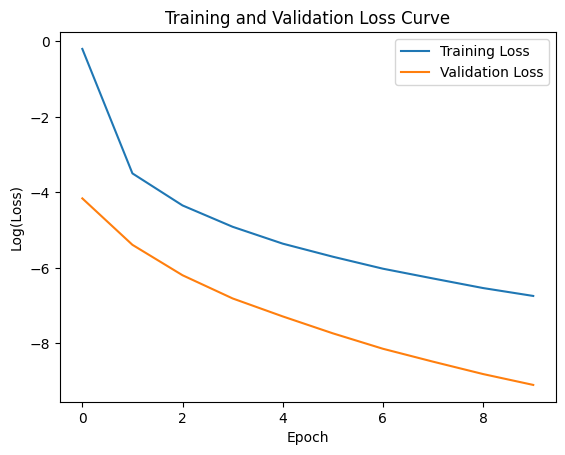

In [ ]:
# Plot the training and validation loss curve
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Log(Loss)')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.show()

In [ ]:
from tensorflow_addons.layers import TransformerEncoder, TransformerDecoder
from tensorflow.keras.layers import Dense, Dropout

# Next, we build a deep network.
# The first layer is a TransformerEncoder layer followed by a TransformerDecoder layer.
# Dropout is also applied after each layer to control overfitting.
# Final layer is a Dense output layer with single unit and sigmoid activation since this is a binary classification problem.
# build the network

# Initializes a sequential model, which allows you to build a model layer by layer.
model = Sequential()

# Adds a TransformerEncoder layer to the model.
model.add(TransformerEncoder(
    head_size=64,
    num_heads=8,
    ff_dim=256,
    dropout=0.2,
    input_shape=(sequence_length, nb_features)
))

# Adds a TransformerDecoder layer to the model.
model.add(TransformerDecoder(
    head_size=64
    num_heads=8,
    ff_dim=256,
    dropout=0.2
))
model.add(Dropout(0.2))

# Adds a dense (fully connected) layer to the model with a softmax activation function. This layer produces the output classes.
model.add(Dense(units=nb_out, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

# fit the network
history = model.fit(seq_array, dummy_label_array, epochs=100, batch_size=200, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

# list all data in history
print(history.history.keys())

SyntaxError: invalid syntax. Perhaps you forgot a comma? (<ipython-input-56-159bd02004c0>, line 24)

# Every time I retrain the algorithm I get different training results, i.e., also different evaluation of the decisions

## Model Evaluation on Validation set created during the training (i.e., validation_split=0.05)

In [ ]:
# summarize history for Accuracy
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# fig_acc.savefig("model_accuracy.png")

In [ ]:
# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# fig_acc.savefig("model_loss.png")

# training metrics
scores = model.evaluate(seq_array, dummy_label_array, verbose=1, batch_size=200)
print('Accurracy: {}'.format(scores[1]))

`y_pred = (model.predict(seq_array) > 0.5).astype("int32"):` Predicts the abels for the input sequences using the trained model. The predictions are hresholded at 0.5, meaning that any output probability greater than 0.5 is considered as class 1, otherwise class 0. The predictions are then converted to integers (0 or 1).<br>

`y_true = dummy_label_array:` Sets the true labels from the dummy label array, which represents the actual labels of the data.
then print the **confusion_matrix**

`cm = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1)):` Computes the confusion matrix using the true labels (`y_true`) and the predicted labels `(y_pred). argmax(axis=1)` is used to convert one-hot encoded labels back to their original integer form before computing the confusion matrix.




In [ ]:
# make predictions and compute confusion matrix
# y_pred = model.predict_classes(seq_array,verbose=1, batch_size=200)
y_pred = (model.predict(seq_array) > 0.5).astype("int32") # this way (>0.5) the outcome goes from a probability to 0,1
y_true = dummy_label_array

# test_set = pd.DataFrame(y_pred)
# # test_set.to_csv('binary_submit_train.csv', index = None)

print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))
print(cm)

## Second PdM policy evaluation on the test set.

For each test set, I need to give the on-line sensor data as input to the trained Transformer.


In [ ]:
if os.path.isfile(model_path):
    estimator = load_model(model_path)

In [ ]:
# Assumptions for the costs, taken by the 2019 RESS paper
C_p    = 100
C_c    = 1000
C_unav = 10
C_inv  = 1
DT     = 10  # Decisions can be taken every DT=10
L      = 20  # lead time

In [ ]:
array_decisions = np.arange(0,400,10) # decisions can only be made every DT = 10 cycles

In [ ]:
# estimator.predict(seq_array_validation_k).reshape(3) returns a vector with 3 elements
# [Pr(RUL>w1), Pr(w0<RUL<=w1), Pr(RUL<=w0)]

In [ ]:
test_df['cycle_norm'] = test_df['cycle']

In [ ]:
test_df.head()

## Second PdM policy evaluation on a the whole validation data set (ids 81 to 100)


In [ ]:
costs_rep_array   = np.zeros(20) # An array to store costs related to replacements.

costs_delay_array = np.zeros(20) # An array to store costs related to delays.
costs_stock_array = np.zeros(20) # An array to store costs related to stock.

t_LC_array        = np.zeros(20) # An array to store lead time.
t_order_array     = np.zeros(20) # An array to store order time.

> 1. Initializes a counter variable to 0.
> 2. Iterates over unique IDs in the `test_df` DataFrame.
> 3. For each ID:
>> * Sets flags for preventive replacement and ordering to False.<br>
>> * Iterates over cycles within the range of the DataFrame.<br>
>> * Checks if the current cycle is in the `array_decisions`.<br>
>> * If it is, preprocesses the validation data for the LSTM model.<br>
>> * Predicts the probability of RUL being smaller than w1 and DT (decision time) using the trained model.<br>
>> * Evaluates decision heuristics:
>>> * If no order has been placed yet and the cost of preventive replacement is less than or equal to the cost of waiting until `w1`, orders the component and sets the order time.<br>
>>> * If the cost of preventive replacement is less than or equal to the cost of waiting until `DT`, performs preventive replacement, calculates related costs, and breaks the loop.<br>
>> If preventive replacement is not performed:
>>> * Sets the component failure time to the last cycle in the ID's data.<br>
>>> * Sets replacement costs to `C_c`.<br>
>>> * Calculates delay costs based on whether an order has been placed.<br>
>> * Prints diagnostic information for each iteration.
>> * Increments the counter.


This code essentially simulates a decision-making process for component maintenance based on predictive models and cost considerations.








In [ ]:
counter = 0
for id in test_df['id'].unique():
    print('ID:', id)
    preventive_replacement = False
    order                  = False

    for cycle in range(test_df[test_df['id']==id].shape[0]-sequence_length+1):

        if cycle in array_decisions:

            norm_validation_df = pd.DataFrame(min_max_scaler.transform(test_df[test_df['id']==id][cols_normalize][:sequence_length+cycle]),
                 columns=cols_normalize,
                 index=test_df[test_df['id']==id][:sequence_length+cycle].index)

            join_df = test_df[test_df['id']==id][:sequence_length+cycle][test_df[test_df['id']==id][:sequence_length+cycle].columns.difference(cols_normalize)].join(norm_validation_df)
            validation_df_eval_online = join_df.reindex(columns = test_df[test_df['id']==id][cycle:sequence_length+cycle].columns)

            seq_array_validation_k = validation_df_eval_online[sequence_cols].values[cycle:sequence_length+cycle]
            seq_array_validation_k = np.asarray(seq_array_validation_k).astype(np.float32).reshape(1,sequence_length, nb_features)
            prob_RUL_smaller_DT    = estimator.predict(seq_array_validation_k).reshape(3)[2]
            prob_RUL_smaller_w1    = estimator.predict(seq_array_validation_k).reshape(3)[1]

            print('prob_RUL_smaller_w1:', prob_RUL_smaller_w1)
            print('prob_RUL_smaller_DT:', prob_RUL_smaller_DT)


            # evaluate decision heuristics
            if order == False:
                if C_p <= prob_RUL_smaller_w1*C_c:
                    print('prob_RUL_smaller_w1:', prob_RUL_smaller_w1)
                    print('prob_RUL_smaller_DT:', prob_RUL_smaller_DT)
                    t_order_array[counter] = sequence_length+cycle
                    order = True
                    print('component ordering at cycle:', t_order_array[counter])

            if C_p <= prob_RUL_smaller_DT*C_c:
                print('prob_RUL_smaller_DT:', prob_RUL_smaller_DT)

                t_LC_array[counter] = sequence_length+cycle
                costs_rep_array[counter] = C_p
                print('preventive replacement informed at cycle:', t_LC_array[counter])
                # print('component lifecycle:', t_LC)
                preventive_replacement = True
                costs_delay_array[counter] = max(t_order_array[counter]+L-t_LC_array[counter], 0) * C_unav

                costs_stock_array[counter]  = max(t_LC_array[counter] -(t_order_array[counter]+L), 0)*C_inv
                # print('delay time', max(t_order+L-t_LC, 0))
                # print('cost_delay_id:',cost_delay_id)
                # print('cost of stock:', cost_stock_id)
                break

    if preventive_replacement == False:
        t_LC_array[counter] = test_df[test_df['id']==id]['cycle'].iloc[-1]
        print('Component failure at t:', t_LC_array[counter])
        costs_rep_array[counter] = C_c

        if order == False:
            costs_delay_array[counter] = L * C_unav
        else:
            costs_delay_array[counter] = max(t_order_array[counter]+L-t_LC_array[counter], 0) * C_unav
            costs_stock_array[counter] = max(t_LC_array[counter] -(t_order_array[counter]+L), 0)*C_inv

    print('True failure:', test_df[test_df['id']==id]['cycle'].iloc[-1])
    print('-----------------------------------------')
    counter+=1

In [ ]:
costs_rep_array

In [ ]:
costs_delay_array

In [ ]:
costs_stock_array

In [ ]:
costs_tot = costs_rep_array+costs_delay_array+costs_stock_array

In [ ]:
costs_tot

In [ ]:
t_LC_array

In [ ]:
t_order_array

### This code calculates the expected cost per unit time using the LSTM model. It computes the mean of the total costs divided by the mean of the time to component failure (t_LC_array). This metric gives an estimate of the average cost incurred per unit time in the system, considering both maintenance and operational costs.

In [ ]:
expected_cost_LSTM = np.mean(costs_tot) / np.mean(t_LC_array)
expected_cost_LSTM

This code segment calculates the expected cost per unit time assuming perfect prognostics.
`1. Perfect Prognostics Calculation:`
> * It initializes an array `t_LC_perfect_array` to store the time of component failure for each unit in the validation dataset. This is calculated by dividing the last observed cycle number by the decision interval DT and then flooring the result to get the last decision cycle before failure.
> * The loop iterates over each unique ID in the validation dataset, calculates the time of component failure for each unit, and stores it in
`t_LC_perfect_array`.<br>
> * `math.floor()` is used to round down the result to the nearest multiple of `DT`.
> * Finally, the loop increments the counter for each unit.<br>

`2. Cost Calculation:`
> * `costs_perfect_array` is initialized with a value of `C_p`, representing the cost of preventive replacements. In a perfect scenario, only preventive replacements are made.
> * This array holds the same cost value for each unit in the validation dataset.

`3. Expected Cost Calculation:`
> * `expected_cost_perfect` is calculated by taking the mean of `costs_perfect_array` and dividing it by the mean of `t_LC_perfect_array`.
> * This calculation provides an estimate of the average cost per unit time assuming perfect prognostics, where components are replaced preventively at regular intervals.









In [ ]:
# Perfect prognostics
import math
t_LC_perfect_array  = np.zeros(20)
counter=0
for id in validation_df['id'].unique():
    t_LC_perfect_array[counter] = math.floor(validation_df[validation_df['id']==id]['cycle'].iloc[-1] /DT) * DT
    counter+=1

costs_perfect_array = np.ones(20)*C_p # a perfect policy will only lead to preventive replacements

expected_cost_perfect = np.mean(costs_perfect_array)/np.mean(t_LC_perfect_array)
expected_cost_perfect


In [ ]:
t_LC_perfect_array

In [ ]:
# evaluation of the metric defined in the paper
M = (expected_cost_LSTM - expected_cost_perfect) / expected_cost_perfect
M # it obtains a very small value

In [ ]:
M*100